# EnKF Experiments - GCS

## Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.stats import shapiro, kruskal
import seaborn as sns
import sys

In [2]:
sys.path.append('../../../../stationsim/')
from ensemble_kalman_filter import EnsembleKalmanFilter, AgentIncluder
from stationsim_gcs_model import Model

In [3]:
sys.path.append('../')
from experiment_utils import Modeller, Processor, Visualiser

In [4]:
%matplotlib inline
np.random.seed(42)

## Functions

In [5]:
def tidy_dataframe(df, independent_col: str, dependent_cols: list):
    output = list()
    
    for i, row in df.iterrows():
        for col in dependent_cols:
            d = {independent_col: row[independent_col],
                 'variable':  col,
                 'value': row[col]}
            output.append(d)
    
    output = pd.DataFrame(output)
    return output

In [6]:
def reduce_results(df, threshold=1):
    # Remove rows that are full of na's for all variables
    variable_names = ['forecast', 'obs', 'analysis', 'baseline']
    df = df.loc[~df[variable_names].isna().all(axis=1), :]
    print(f"Non-na times: {df['time'].max()} - {df['time'].min()}")

    # Identify times for which there are less than or equal to the threshold number of rows
    low_entry_series = df['time'].value_counts() <= threshold
    # Get set of unique times
    low_entry_times = set(low_entry_series[low_entry_series].index)

    times = set(df['time'].unique())
    keep_times = times - low_entry_times
    print(f'Low entry times: {max(low_entry_times)} - {min(low_entry_times)}')
    print(f'Times: {max(times)} - {min(times)}')
    print(f'Times to keep: {max(keep_times)} - {min(keep_times)}')
    results = df.loc[df['time'].isin(keep_times), :]

    return results

## Data paths

In [6]:
data_dir = '../results/data/exp2/'
model_dir = '../results/models/exp2/'
fig_dir = '../results/figures/exp2/'

## Experiment 1 - Setting Up EnKF

### Base model inclusion in error calculations

In [7]:
Modeller.run_experiment_2(pop_size=20, inclusion=AgentIncluder.BASE)

  0%|          | 0/10 [00:00<?, ?it/s]../../../../stationsim/ensemble_kalman_filter.py:173: RuntimeWarning: EnKF received unexpected attribute (vanilla_ensemble_size).
  warns.warn(w, RuntimeWarning)
/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE


 10%|█         | 1/10 [01:49<16:23, 109.23s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE


 20%|██        | 2/10 [04:17<17:35, 131.92s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE


 30%|███       | 3/10 [06:36<15:46, 135.23s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE


 40%|████      | 4/10 [08:43<13:12, 132.13s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE


 50%|█████     | 5/10 [10:44<10:39, 127.97s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE


 60%|██████    | 6/10 [12:54<08:34, 128.71s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE


 70%|███████   | 7/10 [14:22<05:46, 115.46s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE


 80%|████████  | 8/10 [16:11<03:46, 113.25s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE


 90%|█████████ | 9/10 [18:24<01:59, 119.57s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.BASE


100%|██████████| 10/10 [20:23<00:00, 122.35s/it]


In [8]:
Processor.process_experiment_2()

#### Read data

In [7]:
results = pd.read_csv(data_dir + 'p20/metrics.csv')
results.head()

,time,forecast,obs,analysis,baseline
0,0,NaN,NaN,NaN,NaN
1,20,43.242115,1.161471,0.341145,45.510068
2,40,27.014921,0.873187,0.481068,63.425996
3,60,1.920406,1.396243,0.364118,54.597030
4,80,24.633005,0.928370,0.419037,61.676652


In [8]:
results.shape

(2043, 5)

#### Tidy up data

In [9]:
error_types = ['forecast', 'obs', 'analysis', 'baseline']

In [10]:
tidy_df = tidy_dataframe(results, 'time', error_types)
tidy_df.head()

,time,variable,value
0,0.0,forecast,NaN
1,0.0,obs,NaN
2,0.0,analysis,NaN
3,0.0,baseline,NaN
4,20.0,forecast,43.242115


#### Plot results - mean

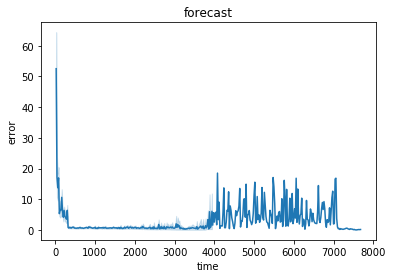

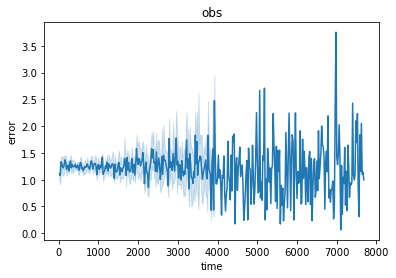

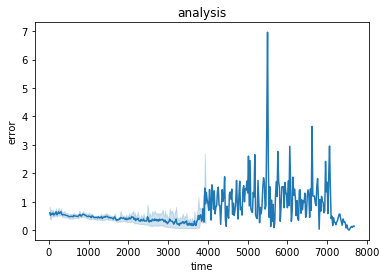

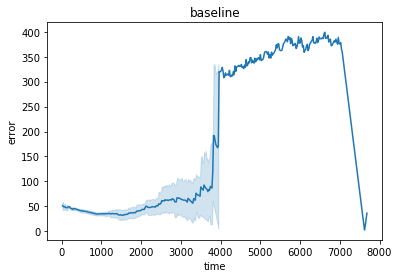

In [11]:
for error_type in error_types:
    df = tidy_df.loc[tidy_df['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df)
    plt.ylabel('error')
    plt.title(error_type)
    plt.savefig(fig_dir + f'exp_2_BASE_mean_{error_type}.pdf')
    plt.show()

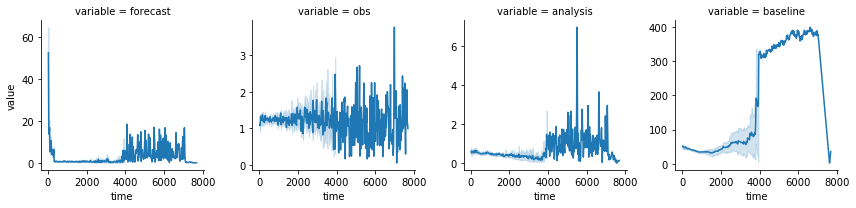

In [12]:
g = sns.FacetGrid(tidy_df, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value')
g.savefig(fig_dir + 'exp_2_BASE_mean_facet.pdf')

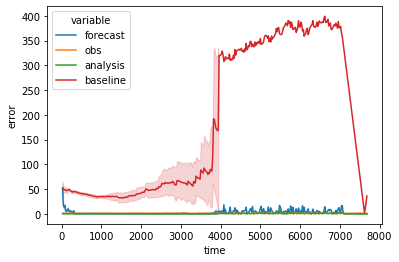

In [13]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_BASE_mean.pdf')
plt.show()

##### Exclude baseline

In [14]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']!='baseline'), :]

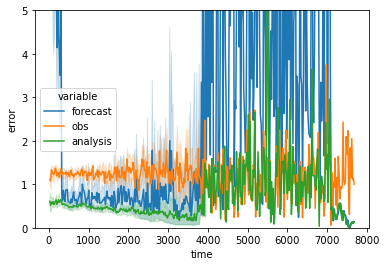

In [15]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df)
plt.ylabel('error')
plt.ylim(0, 5)
plt.savefig(fig_dir + 'exp_2_BASE_mean_nobaseline.pdf')
plt.show()

##### Only baseline and analysis

In [16]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']=='baseline') | (tidy_df['variable']=='analysis'), :]

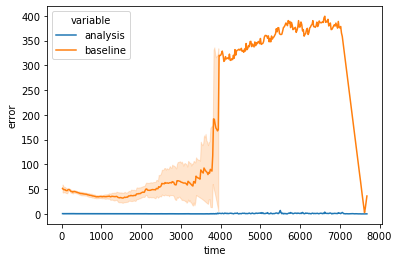

In [17]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_BASE_mean_reduced.pdf')
plt.show()

#### Plot results - median

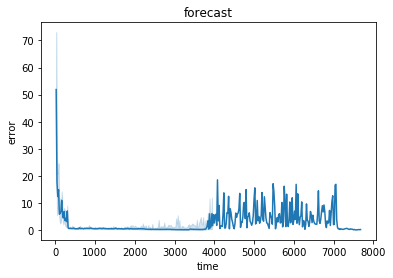

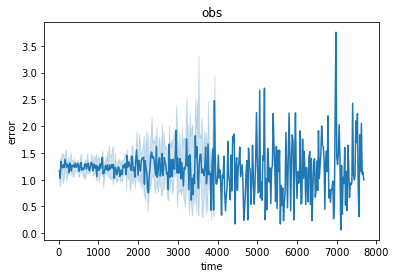

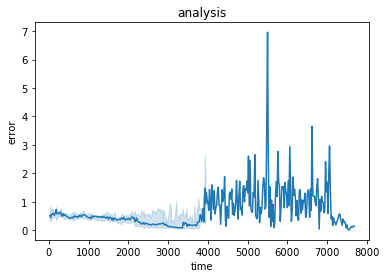

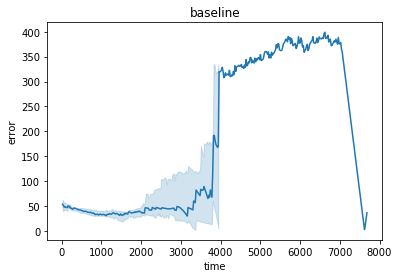

In [18]:
for error_type in error_types:
    df = tidy_df.loc[tidy_df['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df, estimator=np.median)
    plt.ylabel('error')
    plt.title(error_type)
    plt.savefig(fig_dir + f'exp_2_BASE_median_{error_type}.pdf')
    plt.show()

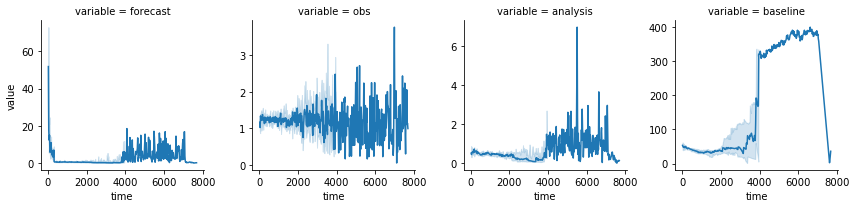

In [19]:
g = sns.FacetGrid(tidy_df, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value', estimator=np.median)
g.savefig(fig_dir + 'exp_2_BASE_median_facet.pdf')

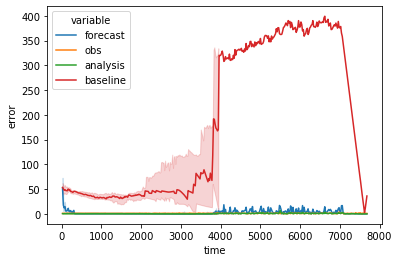

In [20]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df, estimator=np.median)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_BASE_median.pdf')
plt.show()

##### Exclude baseline

In [21]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']!='baseline'), :]

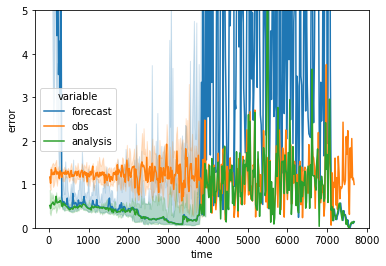

In [22]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df, estimator=np.median)
plt.ylabel('error')
plt.ylim(0, 5)
plt.savefig(fig_dir + 'exp_2_BASE_median_nobaseline.pdf')
plt.show()

##### Only baseline and analysis

In [23]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']=='baseline') | (tidy_df['variable']=='analysis'), :]

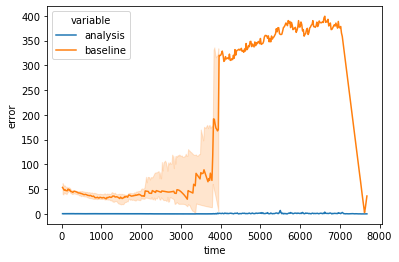

In [24]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df, estimator=np.median)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_BASE_median_reduced.pdf')
plt.show()

### Ensemble mode inclusion in error calculations

In [46]:
Modeller.run_experiment_2(pop_size=20, inclusion=AgentIncluder.MODE_EN)

  0%|          | 0/10 [00:00<?, ?it/s]../../../../stationsim/ensemble_kalman_filter.py:173: RuntimeWarning: EnKF received unexpected attribute (vanilla_ensemble_size).
  warns.warn(w, RuntimeWarning)
/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.MODE_EN


 10%|█         | 1/10 [01:52<16:52, 112.55s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.MODE_EN


 20%|██        | 2/10 [03:37<14:25, 108.20s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.MODE_EN


 30%|███       | 3/10 [06:16<15:17, 131.13s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.MODE_EN


 40%|████      | 4/10 [08:39<13:34, 135.82s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.MODE_EN


 50%|█████     | 5/10 [10:46<11:04, 132.82s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.MODE_EN


 60%|██████    | 6/10 [12:31<08:13, 123.26s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.MODE_EN


 70%|███████   | 7/10 [14:57<06:32, 130.77s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.MODE_EN


 80%|████████  | 8/10 [17:39<04:41, 140.85s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.MODE_EN


 90%|█████████ | 9/10 [19:34<02:12, 132.64s/it]

Running Ensemble Kalman Filter...
max_iterations:	20000
ensemble_size:	20
assimilation_period:	20
pop_size:	20
filter_type:	EnsembleKalmanFilterType.STATE
inclusion_type:	AgentIncluder.MODE_EN


100%|██████████| 10/10 [21:34<00:00, 129.44s/it]


In [47]:
Processor.process_experiment_2()

#### Read data

In [25]:
results = pd.read_csv(data_dir + 'p20/metrics.csv')
results.head()

,time,forecast,obs,analysis,baseline
0,0,NaN,NaN,NaN,NaN
1,20,43.242115,1.161471,0.341145,45.510068
2,40,27.014921,0.873187,0.481068,63.425996
3,60,1.920406,1.396243,0.364118,54.597030
4,80,24.633005,0.928370,0.419037,61.676652


In [26]:
results.shape

(2043, 5)

#### Tidy up data

In [27]:
error_types = ['forecast', 'obs', 'analysis', 'baseline']

In [28]:
tidy_df = tidy_dataframe(results, 'time', error_types)
tidy_df.head()

,time,variable,value
0,0.0,forecast,NaN
1,0.0,obs,NaN
2,0.0,analysis,NaN
3,0.0,baseline,NaN
4,20.0,forecast,43.242115


#### Plot results - mean

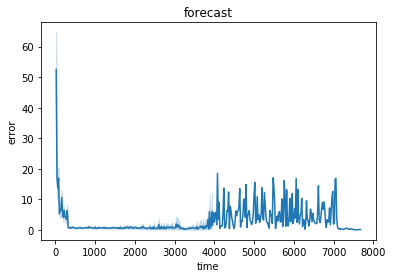

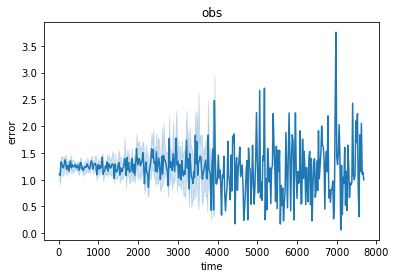

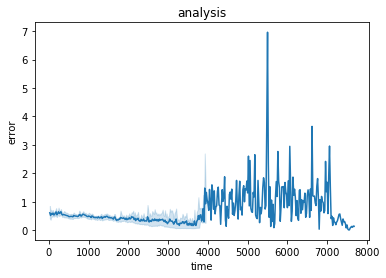

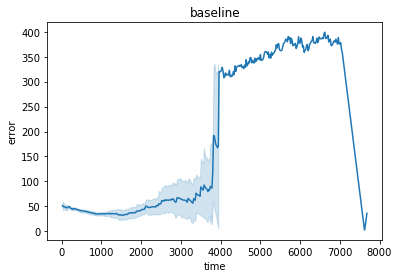

In [29]:
for error_type in error_types:
    df = tidy_df.loc[tidy_df['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df)
    plt.ylabel('error')
    plt.title(error_type)
    plt.savefig(fig_dir + f'exp_2_MODE_EN_mean_{error_type}.pdf')
    plt.show()

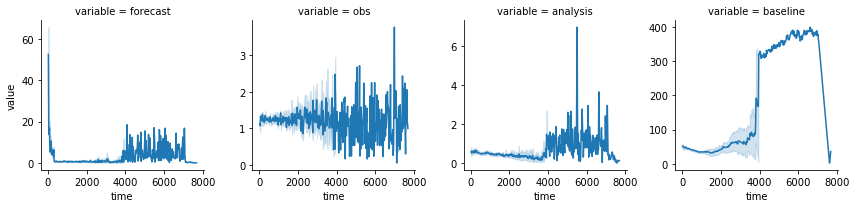

In [30]:
g = sns.FacetGrid(tidy_df, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value')
g.savefig(fig_dir + 'exp_2_MODE_EN_mean_facet.pdf')

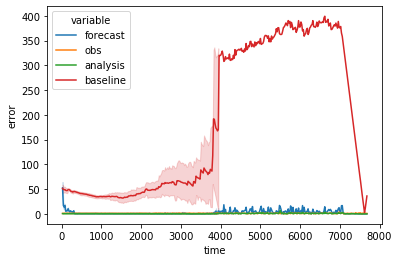

In [31]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_MODE_EN_mean.pdf')
plt.show()

##### Exclude baseline

In [32]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']!='baseline'), :]

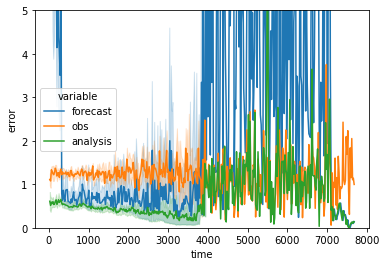

In [33]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df)
plt.ylabel('error')
plt.ylim(0, 5)
plt.savefig(fig_dir + 'exp_2_MODE_EN_mean_nobaseline.pdf')
plt.show()

##### Only baseline and analysis

In [34]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']=='baseline') | (tidy_df['variable']=='analysis'), :]

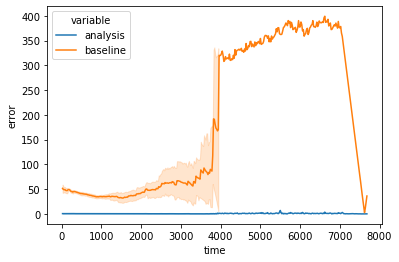

In [35]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_MODE_EN_mean_reduced.pdf')
plt.show()

#### Plot results - median

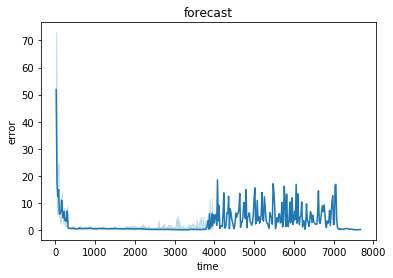

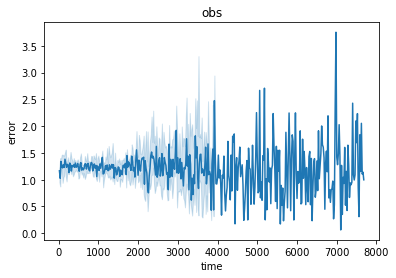

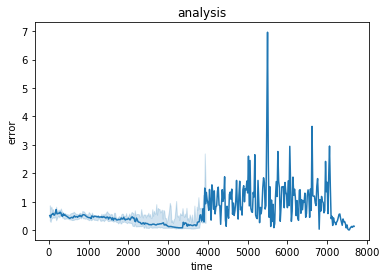

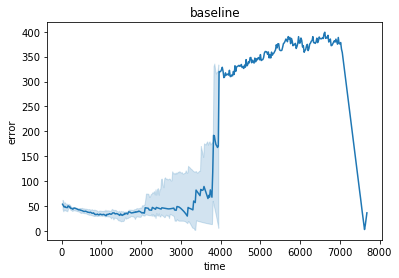

In [36]:
for error_type in error_types:
    df = tidy_df.loc[tidy_df['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df, estimator=np.median)
    plt.ylabel('error')
    plt.title(error_type)
    plt.savefig(fig_dir + f'exp_2_MODE_EN_median_{error_type}.pdf')
    plt.show()

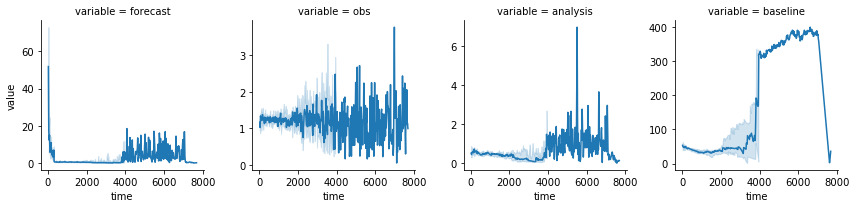

In [37]:
g = sns.FacetGrid(tidy_df, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value', estimator=np.median)
g.savefig(fig_dir + 'exp_2_MODE_EN_median_facet.pdf')

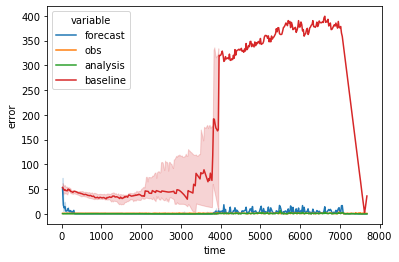

In [38]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df, estimator=np.median)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_MODE_EN_median.pdf')
plt.show()

##### Exclude baseline

In [39]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']!='baseline'), :]

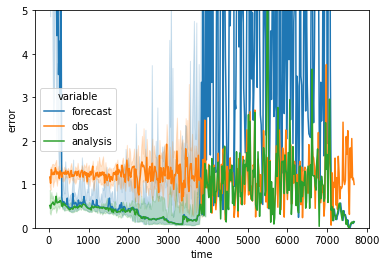

In [40]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df, estimator=np.median)
plt.ylabel('error')
plt.ylim(0, 5)
plt.savefig(fig_dir + 'exp_2_MODE_EN_median_nobaseline.pdf')
plt.show()

##### Only baseline and analysis

In [41]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']=='baseline') | (tidy_df['variable']=='analysis'), :]

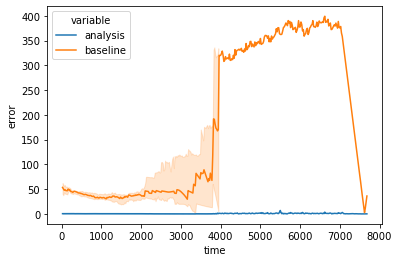

In [42]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df, estimator=np.median)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_2_MODE_EN_median_reduced.pdf')
plt.show()